## GIS 5572: Lab 2
#### By Zain Ul Abdin Siyal (13-Mar-2024)

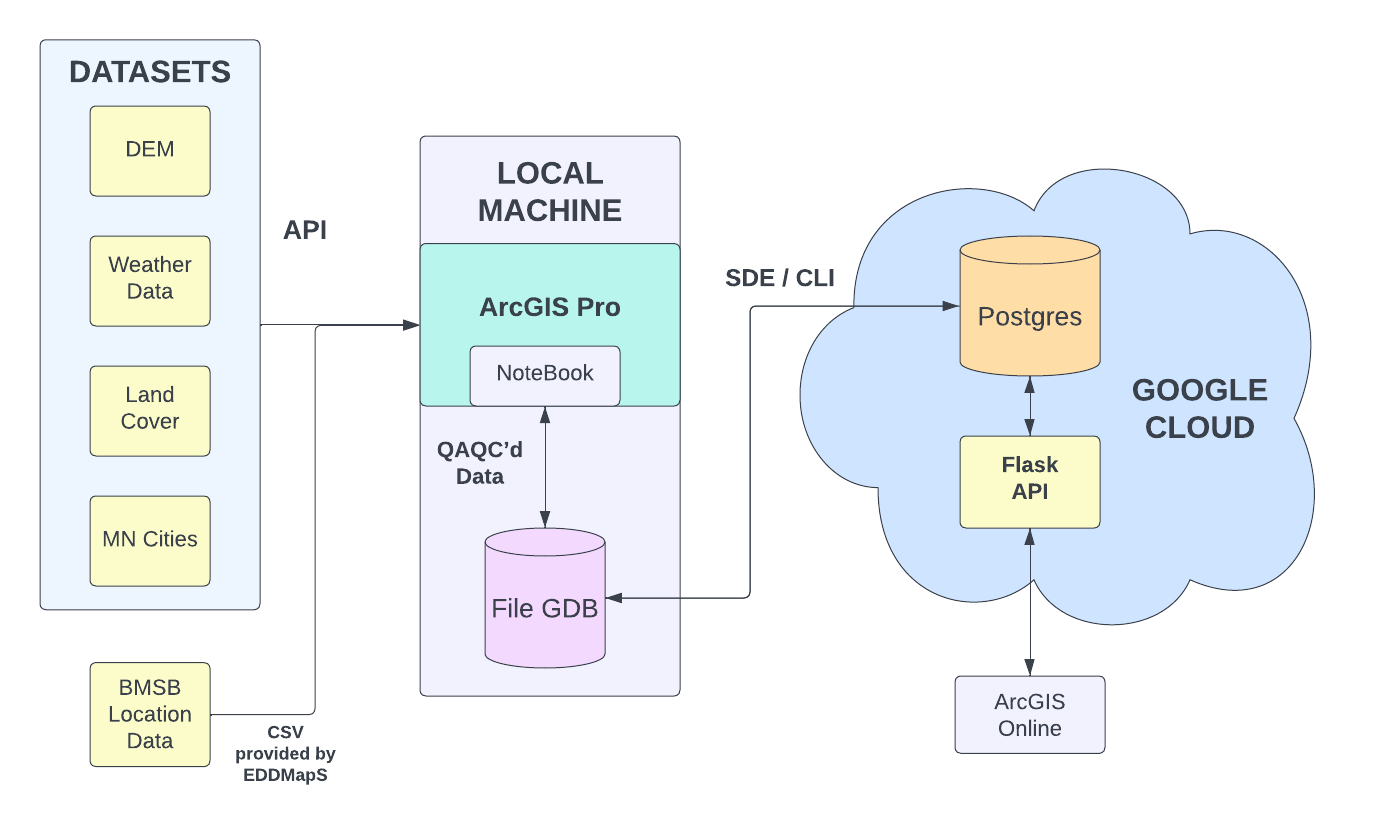

In [12]:
# Set the path to the image file
image_path = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Flow Diagram.png"

# Display the image
Image(image_path)

In [11]:
#Modules required for this lab

# for data manipulation and analysis
import pandas as pd

# for using ArcGIS tools and functionalities
import arcpy

import json

# for making HTTP requests and interacting with web services
import requests

# for interacting with the operating system, managing file paths, and executing system commands
import os

# for working with ArcGIS API for Python
import arcgis

# to handle warnings generated during code execution
import warnings

# to suppress warnings during the execution
warnings.filterwarnings("ignore")

from IPython.display import Image

In [6]:
#path to local database
local_gdb = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb"


# Establish SDE Connection via PGAdmin & Catalog Pane in ArcGIS Pro
sde = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\PostgreSQL-35-lab2(postgres).sde"

In [16]:
sde = {
    "server": "35.226.160.201",
    "database": "gis5572",
    "user": "postgres",
    "password": "*******",
    "port": "5432"
}

### Which Datasets to be Considered
#### Some BMSB Facts

* BMSB activity is highly influenced by temperature. These insects are more active in warmer temperatures and tend to become inactive or seek shelter during colder periods. 

* While precipitation itself may not directly impact the brown marmorated stink bug, weather conditions associated with precipitation, such as increased humidity, can affect their behavior. Stink bugs may seek shelter during rainy or wet conditions.
 
* They are known to seek shelter in human-made structures, including homes, during the winter.
 
* BMSB is a known agricultural pest, and its presence is closely tied to the availability of preferred host plants. They feed on a variety of crops, fruits, and ornamental plants. The presence of suitable host plants influences their distribution and abundance.

## DATA

### BMSB data from EDD Maps

The data was emailed by EDDMapS after the download was selected on the map.
Link here: https://www.eddmaps.org/distribution/viewmap.cfm?sub=9328

In [ ]:
# BMSB csv file path 
bmsb_path = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\BMSB\orig_bmsb_mappings.csv"

#### Data Cleaning: BMSB CSV
* Just reduced the original csv to 6 columns: objectid, ObsDate, Location, Lat, Long, NumCollect
* Only observations from Minnesota by checking if the "Location" column contains the string Minnesota
* Fill missing values in the "NumCollect" column with the value 1
* Drop rows with missing values in the "Latitude" or "Longitude" columns.
* Parse the date strings in the "ObsDate" column to the format "YYYY-MM-DD". Looks checks different date formats ("%m-%d-%y", "%m/%d/%Y") and converts them to the required format.
* Drop rows where the "NumCollect" values are outliers, values greater than 1 SD above/below the mean.
* Check Lat and Long column to keep tose that are within Minnesota boundary

In [15]:
# Loading in BMSB Observations with explicit encoding
bmsb_df_raw = pd.read_csv(bmsb_path, encoding='latin1', low_memory=False)

# Create a copy of the DataFrame with only certain columns
bmsb_df = bmsb_df_raw[["objectid", "ObsDate", "Location", "Latitude", "Longitude", "NumCollect"]].copy()

# Filter rows where Location contains 'Minnesota'
bmsb_df = bmsb_df[bmsb_df["Location"].str.contains("Minnesota")]

# Fill 'NumCollect' Nulls with 1
bmsb_df["NumCollect"].fillna(1, inplace=True)

# Drop rows with Null 'Latitude' or 'Longitude'
bmsb_df = bmsb_df.dropna(subset=["Latitude", "Longitude"])

# Convert data types
bmsb_df["Location"] = bmsb_df["Location"].astype(str)

# Define a function to parse the dates with different formats
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%m-%d-%y').strftime('%Y-%m-%d')  # Try one format and convert to required format
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%m/%d/%Y').strftime('%Y-%m-%d')  # Try another format and convert to required format
        except ValueError:
            return pd.to_datetime(date_str, errors='coerce').strftime('%Y-%m-%d')  # Handle other cases and convert to required format

# Apply the parse_date function to the ObsDate column
bmsb_df["ObsDate"] = bmsb_df["ObsDate"].apply(parse_date)

# Drop rows with invalid dates
bmsb_df = bmsb_df.dropna(subset=["ObsDate"])

# Convert 'NumCollect' to integer after handling NaN values
bmsb_df["NumCollect"] = pd.to_numeric(bmsb_df["NumCollect"], errors='coerce').fillna(1).astype(int)

# Reconfigure the Location Column to just show County Name
bmsb_df["Location"] = bmsb_df["Location"].apply(lambda x: x.replace('"', ''))
bmsb_df["County"] = bmsb_df["Location"].apply(lambda x: x.split(",")[0])
bmsb_df = bmsb_df.drop(["Location"], axis=1)

# Drop rows where 'NumCollect' < 1
bmsb_df = bmsb_df[bmsb_df["NumCollect"] >= 1]

# Drop rows where 'NumCollect' are outliers (> 1 Std Dev above the Mean)
numMean = bmsb_df["NumCollect"].mean()
numStd = bmsb_df["NumCollect"].std()
bmsb_df = bmsb_df[(bmsb_df["NumCollect"] >= numMean - numStd) & (bmsb_df["NumCollect"] <= numMean + numStd)]

# Drop rows where Lat/Lon are outside MN BBox
bmsb_df = bmsb_df[(bmsb_df["Longitude"] > -97.5) & (bmsb_df["Longitude"] < -89.0) & (bmsb_df["Latitude"] > 43.0) & (bmsb_df["Latitude"] < 49.5)]

# Save the cleaned DataFrame to a CSV file named "cleaned_bsmb_mapping.csv"
bmsb_df.to_csv(r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\BMSB\clean_bsmb_mapping.csv', index=False)

# Display the cleaned DataFrame
print("Cleaned BMSB Mapping DataFrame:")
print(bmsb_df)


Cleaned BMSB Mapping DataFrame:
       objectid     ObsDate  Latitude  Longitude  NumCollect      County
12      3064751  2012-11-13  44.69626  -93.23961           1      Dakota
13      3064753  2012-05-01  44.96155  -93.35421           1    Hennepin
14      3064754  2011-12-26  45.03817  -93.29792           1    Hennepin
15      3064755  2010-11-24  44.98201  -92.95157           1  Washington
16      3064756  2010-12-07  45.16062  -93.13609           1       Anoka
...         ...         ...       ...        ...         ...         ...
97408  11329748  2023-04-12  44.15021  -94.02069           1  Blue Earth
97430  11485325  2023-08-11  44.96260  -93.44593           1    Hennepin
97431  11492314  2023-08-20  44.92603  -93.45194           1    Hennepin
97432  11560537  2023-10-05  44.96261  -93.44591           1    Hennepin
97451  11546202  2023-09-19  44.59913  -93.29188           1       Scott

[1494 rows x 6 columns]


#### Export from local FGDB to PostgresSQL
* Upload vector feature layer to SDE using arcpy.FeatureClassToFeatureClass_conversion function 

In [16]:
# Function to upload feature class to SDE
def upload_feature_class_to_sde(input_feature_class, output_sde_connection, output_sde_feature_class):
    try:
        arcpy.FeatureClassToFeatureClass_conversion(input_feature_class, output_sde_connection, output_sde_feature_class)
        print(f"Feature class '{output_sde_feature_class}' uploaded successfully to SDE.")
    # function uses a try-except block to handle potential errors during the feature class conversion
    except Exception as e:
        print(f"Error uploading feature class to SDE: {str(e)}")

# Paths and parameters
input_feature_class = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb\clean_bsmb_mapping1'
output_sde_connection = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\PostgreSQL-35-gis5572(postgres).sde'
output_sde_feature_class = 'clean_bmsb_mapping'

# Upload feature class to SDE
upload_feature_class_to_sde(input_feature_class, output_sde_connection, output_sde_feature_class)

Feature class 'clean_bmsb_mappinge' uploaded successfully to SDE.


##### Export Vector via CLI
shp2pgsql -s 26915 -I "F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\BMSB\clean_bsmb_mapping.shp" bmsb_mapping | psql -h 35.226.160.201 -d gis5572 -U postgres -p 5432

In [33]:
import csv
import psycopg2

# Establish connection to PostgreSQL
conn = psycopg2.connect(
    host="35.226.160.201",
    database="gis5572",
    user="postgres",
    password="Hyderabad43%",  
    port="5432"  # Add comma here
)

# Open a cursor to perform database operations
cur = conn.cursor()

# Define the query to select data from the PostgreSQL table
query = "SELECT * FROM clean_bsmb_mapping"

# Execute the query
cur.execute(query)

# Fetch all the rows from the cursor
rows = cur.fetchall()

# Close the cursor and the connection
cur.close()
conn.close()

# Define the path to the CSV file
csv_path = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\BMSB\clean_bsmb_mapping.csv'

# Write the data to the CSV file
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    # Write the header row
    writer.writerow([desc[0] for desc in cur.description])
    # Write the data rows
    writer.writerows(rows)

print("Data exported successfully to CSV file:", csv_path)

UndefinedTable: relation "clean_bsmb_mapping" does not exist
LINE 1: SELECT * FROM clean_bsmb_mapping
                      ^


In [24]:
import arcpy

# Set the workspace where the table will be created
arcpy.env.workspace = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb'  

# Define the name of the table
table_name = 'clean_bsmb_mapping'

# Create the table
arcpy.management.CreateTable(arcpy.env.workspace, table_name)

# Add fields to the table
field_names = ['ObsDate', 'Latitude', 'Longitude', 'NumCollect', 'County']  # Remove 'objectid' field
field_types = ['DATE', 'DOUBLE', 'DOUBLE', 'INTEGER', 'TEXT']

for field_name, field_type in zip(field_names, field_types):
    arcpy.management.AddField(table_name, field_name, field_type)

# Define the path to the CSV file
csv_path = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\BMSB\clean_bsmb_mapping.csv'

# Load data from CSV into the table
arcpy.TableToTable_conversion(csv_path, arcpy.env.workspace, table_name)

try:
    # Export the table to PostgreSQL
    output_pg_table = 'clean_bsmb_mapping_pg'  # Name of the table in PostgreSQL
    output_pg_connection = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\PostgreSQL-35-lab2(postgres).sde'  
    arcpy.conversion.TableToTable(table_name, output_pg_connection, output_pg_table)
    print("Table exported successfully to PostgreSQL.")
except arcpy.ExecuteError:
    print(arcpy.GetMessages(2))
except Exception as e:
    print(e)

ERROR 000210: Cannot create output F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\PostgreSQL-35-lab2(postgres).sde\clean_bsmb_mapping_pg
Failed to execute (TableToTable).



### Minnesota State and Cities Boundary Boundary

by MN Geospatial Commons

State: https://gisdata.mn.gov/dataset/bdry-state-of-minnesota

Cities: https://gisdata.mn.gov/dataset/bdry-mn-city-township-unorg

In [59]:
# Path to the state shapefile
mn_state_boundary = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN County Boundaries\mn_county_boundaries"

# Path to the output file geodatabase
local_gdb = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb"

# Use FeatureClassToGeodatabase tool to copy the shapefile to the geodatabase
arcpy.conversion.FeatureClassToGeodatabase(mn_state_boundary, local_gdb)

print("MN Shapefile has been successfully copied to the file geodatabase.")

MN Shapefile has been successfully copied to the file geodatabase.


In [47]:
# Path to the state cities shapefile
mn_state_cities = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN County Boundaries\shp_bdry_mn_city_township_unorg\city_township_unorg"

# Path to the output file geodatabase
local_gdb = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb"

# Use FeatureClassToGeodatabase tool to copy the shapefile to the geodatabase
arcpy.conversion.FeatureClassToGeodatabase(mn_state_cities, local_gdb)

print("MN Cities Shapefile has been successfully copied to the file geodatabase.")

MN Cities Shapefile has been successfully copied to the file geodatabase.


#### Export from local FGDB to PostgresSQL

In [17]:
# Function to upload feature class to SDE
def upload_feature_class_to_sde(input_feature_class, output_sde_connection, output_sde_feature_class):
    try:
        arcpy.FeatureClassToFeatureClass_conversion(input_feature_class, output_sde_connection, output_sde_feature_class)
        print(f"Feature class '{output_sde_feature_class}' uploaded successfully to SDE.")
    # function uses a try-except block to handle potential errors during the feature class conversion
    except Exception as e:
        print(f"Error uploading feature class to SDE: {str(e)}")

# Paths and parameters
input_feature_class = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb\cities'
output_sde_connection = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\PostgreSQL-35-gis5572(postgres).sde'
output_sde_feature_class = 'cities'

# Upload feature class to SDE
upload_feature_class_to_sde(input_feature_class, output_sde_connection, output_sde_feature_class)

Feature class 'cities' uploaded successfully to SDE.


#### Export Vector via CLI
shp2pgsql -s 26915 -I "F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN County Boundaries\mncities.shp" mncities | psql -h 35.226.160.201 -d gis5572 -U postgres -p 5432

### Weather Data
The Mesonet API is designed to allows users to access data collected by the Iowa State University Mesonet network. Mesonet is a network of environmental monitoring stations that collect and provide real-time data on weather and environmental conditions.

The provided URL points to a GeoJSON file containing daily weather observations for weather stations in Minnesota (MN) for the month of February 2024.The observations include details such as temperature (both maximum and minimum), precipitation, wind speed, and humidity for each station. 

In [3]:
# URL for retrieving GeoJSON weather data
weather_url = r"https://mesonet.agron.iastate.edu/api/1/daily.geojson?network=MN_RWIS&month=2&year=2024"

In [4]:
# Send a GET request to the URL
response = requests.get(weather_url)

In [7]:
# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON data
    weather_data = response.json()

    # Save the GeoJSON data to a file named 'weather_data_feb24.geojson'
    with open('weather_data_feb24.geojson', 'w') as file:
        json.dump(weather_data, file)

    print("GeoJSON data has been successfully saved as 'weather_data_feb24.geojson'")

    # Convert GeoJSON to feature class in file geodatabase
    arcpy.conversion.JSONToFeatures('weather_data_feb24.geojson', f'{local_gdb}\\weather_data')
    print("Weather GeoJSON data has been successfully converted and saved to the file geodatabase.")
else:
    print(f"Error: Unable to fetch data. Status code: {response.status_code}")

GeoJSON data has been successfully saved as 'weather_data_feb24.geojson'
Weather GeoJSON data has been successfully converted and saved to the file geodatabase.


#### Data Transformation and Cleaning: Weather GeoJSON 
* Fill missing values in the 'precip' column with 0.
* Drop rows with null latitude or longitude values.
* Convert data types: 'station' and 'name' to string, and 'date' to datetime.
* Remove outliers for the 'max_tmpf' column based on the assumption of a normal distribution.

#### Cleaning the Waether Data

In [86]:
# Fetch weather data and create a DataFrame
weather_response = requests.get(weather_url)
weather_json = weather_response.json()["features"]
weather_df_raw = pd.DataFrame.from_records(weather_json)

# Function to extract properties from dictionaries as DataFrame columns
def extractToCol(field):
    weather_df_raw[field] = weather_df_raw["properties"].apply(lambda x: dict(x).get(field))

# Define the list of properties to extract
weather_props = ["date", "station", "name", "min_tmpf", "max_tmpf", "precip"]

# Extract properties from dictionaries and create DataFrame columns
for i in weather_props:
    extractToCol(i)


# Extract geometry information (longitude and latitude) and create new columns in the DataFrame.
weather_df_raw["x"] = weather_df_raw["geometry"].apply(lambda x: dict(x)["coordinates"][0])
weather_df_raw["y"] = weather_df_raw["geometry"].apply(lambda x: dict(x)["coordinates"][1])


# Copying Relevant Columns to a New DataFrame:
weather_df = weather_df_raw[["date", "station", "name", "min_tmpf", "max_tmpf", "precip", "x", "y"]].copy()

# Display summary statistics of the original DataFrame
print("Original DataFrame Summary:")
print(weather_df.describe())

# Fill NaN values in 'precip' with 0
weather_df["precip"].fillna(0, inplace=True)

# Display summary statistics after filling null values
print("\nDataFrame After Filling Nulls:")
print(weather_df.describe())

# Drop rows with null latitude or longitude values
weather_df = weather_df.dropna(subset=["x", "y"])

# Display summary statistics after dropping null values
print("\nDataFrame After Dropping Nulls:")
print(weather_df.describe())

# Convert data types
# "station" to string, "name" to string, and "date" to datetime.
weather_df["station"] = weather_df["station"].astype(str)
weather_df["name"] = weather_df["name"].astype(str)
weather_df["date"] = weather_df["date"].astype('datetime64[ns]')


# Display summary statistics after data type conversion
print("\nDataFrame After Data Type Conversion:")
print(weather_df.describe())

# Drop rows where 'precip' is less than 0
weather_df = weather_df.loc[weather_df["precip"] >= 0]

# Display summary statistics after dropping rows where 'precip' is less than 0
print("\nDataFrame After Dropping Rows with 'precip' < 0:")
print(weather_df.describe())

# Drop outliers for 'max_tmpf'
# Assuming temp. values follow a perfect normal distribution
# approx. 99.7% of the data falls within 3 SDs of the mean
mxtmp_mn = weather_df["max_tmpf"].mean()
mxtmp_std = weather_df["max_tmpf"].std()
weather_df = weather_df.loc[weather_df["max_tmpf"].between(mxtmp_mn - 3 * mxtmp_std, mxtmp_mn + 3 * mxtmp_std)]
# basically removes outliers in the "max_tmpf" column using a threshold of 3 SDs from the mean


# Display summary statistics after dropping max_temp outliers
print("\nDataFrame After Dropping Max Temp Outliers:")
print(weather_df.describe())

# Display summary statistics after commenting out min_temp and precip outlier removal
print("\nDataFrame After Commenting Out Min Temp and Precip Outliers:")
print(weather_df.describe())

# Comment out bounding box filtering
# weather_df = weather_df.loc[(weather_df["x"] > -97.5) & (weather_df["x"] < -89.0) & (weather_df["y"] > 43.0) & (weather_df["y"] < 49.5)]

# Display summary statistics after commenting out bounding box filtering
print("\nDataFrame After Commenting Out Bounding Box Filtering:")
print(weather_df.describe())

# Display the final DataFrame
print("\nFinal DataFrame:")
print(weather_df)

# Save the final DataFrame to a CSV file named "weather.csv" at the specified location
save_path = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\Weather Data\weather.csv'
weather_df.to_csv(save_path, index=False)

Original DataFrame Summary:
          min_tmpf     max_tmpf            x            y
count  4723.000000  4723.000000  4727.000000  4727.000000
mean     19.606373    37.830811   -94.189488    45.936739
std      10.671069    10.724415     1.599272     1.568176
min     -25.239988     2.480000   -97.201698    43.508331
25%      13.460011    31.460010   -95.602127    44.543190
50%      22.280000    38.299988   -94.067093    45.985039
75%      27.319979    45.140022   -92.970467    47.211269
max      42.440020    71.419975   -89.684967    48.970852

DataFrame After Filling Nulls:
          min_tmpf     max_tmpf  precip            x            y
count  4723.000000  4723.000000  4727.0  4727.000000  4727.000000
mean     19.606373    37.830811     0.0   -94.189488    45.936739
std      10.671069    10.724415     0.0     1.599272     1.568176
min     -25.239988     2.480000     0.0   -97.201698    43.508331
25%      13.460011    31.460010     0.0   -95.602127    44.543190
50%      22.280000    

#### Export from local FGDB to PostgreSQL

In [14]:
# Function to upload feature class to SDE
def upload_feature_class_to_sde(input_feature_class, output_sde_connection, output_sde_feature_class):
    try:
        arcpy.FeatureClassToFeatureClass_conversion(input_feature_class, output_sde_connection, output_sde_feature_class)
        print(f"Feature class '{output_sde_feature_class}' uploaded successfully to SDE.")
    except Exception as e:
        print(f"Error uploading feature class to SDE: {str(e)}")

# Paths and parameters
input_feature_class = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb\weather_data'
output_sde_connection = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\PostgreSQL-35-gis5572(postgres).sde'
output_sde_feature_class = 'weather'

# Upload feature class to SDE
upload_feature_class_to_sde(input_feature_class, output_sde_connection, output_sde_feature_class)

Feature class 'weather' uploaded successfully to SDE.


#### Option 2: Export Vector via CLI
shp2pgsql -s 26915 -I "F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\Weather Data\weather.shp" mnweather | psql -h 35.226.160.201 -d gis5572 -U postgres -p 5432

### Land Cover of Minnesota 2019
Source: Natural Resources Department

https://gisdata.mn.gov/dataset/biota-landcover-nlcd-mn-2019

In [29]:
# Set paths to input raster and boundary feature
input_raster = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN 2019 Land Cover\NLCD_2019_Land_Cover.tif"
boundary_feature = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN County Boundaries\mn_county_boundaries.shp"

# Set the output raster path
output_raster = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN 2019 Land Cover\NLCD_2019_Land_Cover_clipped.tif"

# Perform raster clipping
try:
    arcpy.env.workspace = arcpy.env.scratchGDB  # Set workspace to a temporary geodatabase
    arcpy.Clip_management(input_raster, "#", output_raster, boundary_feature, "#", "ClippingGeometry", "MAINTAIN_EXTENT")
    print("Raster clipping completed successfully.")
except arcpy.ExecuteError:
    print(arcpy.GetMessages(2))
except Exception as e:
    print(e)

Raster clipping completed successfully.


In [10]:
# Set the paths to the clipped input raster
mnlandcover_path = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN 2019 Land Cover\NLCD_2019_Land_Cover_clipped.tif"

# Extract the file name from the input raster path
raster_name = arcpy.Describe(mnlandcover_path).baseName

# Sanitize the raster name to remove invalid characters
raster_name = arcpy.ValidateTableName(raster_name, local_gdb)

# Build the full output path within the geodatabase
output_raster = arcpy.os.path.join(local_gdb, raster_name)

# Use the Copy Raster tool to copy the raster to the geodatabase
arcpy.CopyRaster_management(mnlandcover_path, output_raster)

print(f"Raster '{raster_name}' copied to geodatabase.")

Raster 'NLCD_2019_Land_Cover_clipped' copied to geodatabase.


#### QAQC Protocol to check the Raster Datasets 
* It checks if there are any null values present in the raster dataset using the GetRasterProperties function with the "ANYNODATA" property.
* Spatial Resolution (cell size) of the raster dataset is checked using the GetRasterProperties function with the "CELLSIZEX" and "CELLSIZEY" properties.
* Ouliers are checked by comparing the min and max values with the mean value ± 3 times the SD
* CRS check has been done as well
* Check raster if its outside the bounding box > print caution message

In [20]:
def check_raster(file_path, categorical=True, expected_cell_size=None, expected_srid=None, xmin=None, ymin=None, xmax=None, ymax=None):
    """
    Check the quality of a raster dataset.
    """
    # Null Values Check
    null_values = arcpy.management.GetRasterProperties(file_path, "ANYNODATA").getOutput(0)
    null_msg = "Detected: Null values present. Initiating data quality check." if null_values == "1" else "No null values found."
    print(null_msg)

    # Spatial Resolution Check
    x_size = float(arcpy.management.GetRasterProperties(file_path, "CELLSIZEX").getOutput(0))
    y_size = float(arcpy.management.GetRasterProperties(file_path, "CELLSIZEY").getOutput(0))
    resolution_msg = "Spatial resolution matches expected specs." if x_size == expected_cell_size and y_size == expected_cell_size else "Spatial resolution does not meet expected specifications."
    print(resolution_msg)

    # Outliers Check
    if not categorical:
        mean_val = float(arcpy.management.GetRasterProperties(file_path, "MEAN").getOutput(0))
        std_val = float(arcpy.management.GetRasterProperties(file_path, "STD").getOutput(0))
        max_val = float(arcpy.management.GetRasterProperties(file_path, "MAXIMUM").getOutput(0))
        min_val = float(arcpy.management.GetRasterProperties(file_path, "MINIMUM").getOutput(0))
        outliers_msg = "Warning: Outliers detected. Verify data integrity." if min_val < (mean_val - (3 * std_val)) or max_val > (mean_val + (3 * std_val)) else "No outliers found. Data integrity confirmed."
        print(outliers_msg)
    else:
        print("Categorical raster. Outliers not applicable.")

    # CRS Check
    sr = arcpy.Describe(file_path).spatialReference
    crs_msg = f"Coordinate system matches the expected specs: {sr}" if expected_srid is None else "Coordinate system matches expected specification." if arcpy.SpatialReference(expected_srid).factoryCode == sr.factoryCode else "Coordinate system does not match expected specification."
    print(crs_msg)

    # Bounding Box Check
    if None not in [xmin, ymin, xmax, ymax]:
        left = float(arcpy.management.GetRasterProperties(file_path, "LEFT").getOutput(0))
        bottom = float(arcpy.management.GetRasterProperties(file_path, "BOTTOM").getOutput(0))
        right = float(arcpy.management.GetRasterProperties(file_path, "RIGHT").getOutput(0))
        top = float(arcpy.management.GetRasterProperties(file_path, "TOP").getOutput(0))
        bbox_msg = "Caution: Raster extends slightly beyond specified boundary. May require closer inspection." if left < xmin or bottom < ymin or right > xmax or top > ymax else "Raster fits entirely within specified boundary." if left >= xmin and bottom >= ymin and right <= xmax and top <= ymax else "Raster partially outside specified boundary."
        print(bbox_msg)
    else:
        print("Bounding box check skipped.")

In [36]:
# Path to Land Cover Dataset
geodatabase_path = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb"
NLCD_raster = "NLCD_2019_Land_Cover_clipped"
NLCD_raster_path = arcpy.os.path.join(geodatabase_path, NLCD_raster)

#To check the Land Cover Raster
check_raster(NLCD_raster_path, categorical=True, expected_cell_size=30, expected_srid=26915, xmin=-97.5, ymin=43.0, xmax=-89.00, ymax=49.5)

No null values found.
Spatial resolution matches expected specs.
Categorical raster. Outliers not applicable.
Coordinate system matches expected specification.
Caution: Raster extends slightly beyond specified boundary. May require closer inspection.


#### Export to PostgreSQL
* Downsample raster by reducing the resolution of a raster dataset.
* Convert raster to points basically vector format
* Upload Points to SDE using arcpy.FeatureClassToFeatureClass_conversion function 

In [18]:
import arcpy

# Step 1: Downsample Raster
def downsample_raster(input_raster, output_raster, cell_size):
    arcpy.Resample_management(input_raster, output_raster, cell_size)

# Step 2: Convert Raster to Points
def raster_to_points(input_raster, output_points):
    arcpy.RasterToPoint_conversion(input_raster, output_points, "VALUE")

# Step 3: Upload Points to SDE
def upload_points_to_sde(input_points, output_sde_connection, output_sde_feature_class):
    arcpy.FeatureClassToFeatureClass_conversion(input_points, output_sde_connection, output_sde_feature_class)

# Paths and parameters
input_raster = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb\NLCD_2019_Land_Cover_clipped'
output_downsampled_raster = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN 2019 Land Cover\downsampled_nlcdraster.tif'
output_points = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN 2019 Land Cover\nlcd_points.shp'
output_sde_connection = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\PostgreSQL-35-gis5572(postgres).sde'

output_sde_feature_class = 'clean_nlcd_points'

# Step 1: Downsample Raster
downsample_raster(input_raster, output_downsampled_raster, "15000")

# Step 2: Convert Raster to Points
raster_to_points(output_downsampled_raster, output_points)

# Step 3: Upload Points to SDE
upload_points_to_sde(output_points, output_sde_connection, output_sde_feature_class)

#### Export Raster via CLI

raster2pgsql -s 26915 -I -t 128x128 "F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN 2019 Land Cover\NLCD_2019_Land_Cover_clipped.tif" mnlandcover | psql -h 35.226.160.201 -d gis5572 -U postgres -p 5432

### Minnesota Digital Elevation Model - 30 Meter Resolution

This 30 Meter Digital Elevation Model (DEM) is a copy of the USGS 1:24,000 scale Level 2 DEMs for the State.

There are three quadrangles known be be Level 1 DEM data: Town Line Lake (q1925), Grand Portage (q1261) and Grand Portage OE N (q1161).

Source: https://gisdata.mn.gov/dataset/elev-30m-digital-elevation-model

In [34]:
import arcpy

# Set the paths to the input raster and the geodatabase
dem_path = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN DEM\Digital Elevation Model.tif"

# Extract the file name from the input raster path
raster_name = arcpy.Describe(dem_path).baseName

# Sanitize the raster name to remove invalid characters
raster_name = arcpy.ValidateTableName(raster_name, local_gdb)

# Build the full output path within the geodatabase
output_raster = arcpy.os.path.join(local_gdb, raster_name)

# Use the Copy Raster tool to copy the raster to the geodatabase
arcpy.CopyRaster_management(dem_path, output_raster)

print(f"Raster '{raster_name}' copied to geodatabase.")

Raster 'Digital_Elevation_Model' copied to geodatabase.


In [21]:
# Path to Land Cover Dataset
geodatabase_path = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb"
DEM_raster = "Digital_Elevation_Model"
DEM_raster_path = arcpy.os.path.join(geodatabase_path, DEM_raster)

#To check the DEM Raster
check_raster(DEM_raster_path, False, 30, 26915, -97.5, 43.0, -89.00, 49.5)

No null values found.
Spatial resolution matches expected specs.
No outliers found. Data integrity confirmed.
Coordinate system matches expected specification.
Caution: Raster extends slightly beyond specified boundary. May require closer inspection.


#### Export from local FGDB to PostgreSQL

In [19]:
# Step 1: Downsample Raster
def downsample_raster(input_raster, output_raster, cell_size):
    arcpy.Resample_management(input_raster, output_raster, cell_size)

# Step 2: Convert Raster to Points
def raster_to_points(input_raster, output_points):
    arcpy.RasterToPoint_conversion(input_raster, output_points, "VALUE")

# Step 3: Upload Points to SDE
def upload_points_to_sde(input_points, output_sde_connection, output_sde_feature_class):
    arcpy.FeatureClassToFeatureClass_conversion(input_points, output_sde_connection, output_sde_feature_class)

# Paths and parameters
input_raster = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\ArcII_Lab2.gdb\Digital_Elevation_Model'
output_downsampled_raster = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN DEM\downsampled_demraster.tif'
output_points = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN DEM\dem_points.shp'
output_sde_connection = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\ArcPro\Lab2\ArcII_Lab2\PostgreSQL-35-gis5572(postgres).sde'

output_sde_feature_class = 'clean_dem_points'

# Step 1: Downsample Raster
downsample_raster(input_raster, output_downsampled_raster, "15000")

# Step 2: Convert Raster to Points
raster_to_points(output_downsampled_raster, output_points)

# Step 3: Upload Points to SDE
upload_points_to_sde(output_points, output_sde_connection, output_sde_feature_class)

#### Option 2: Export DEM Raster via CLI

raster2pgsql -s 26915 -I -t 128x128 "F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\2. Labs\Lab 02\Data\MN DEM\Digital Elevation Model.tif" mndem1 | psql -h 35.226.160.201 -d gis5572 -U postgres -p 5432